# Tech Challenge - Fase 2

# Fechamento IBOVESPA

## 1. Introdução

### Objetivo
Este projeto tem como objetivo analisar dados históricos do IBOVESPA e construir modelos de Machine LearningCriar que preveja se o fechamento do dia
seguinte será maior ou menor que o do dia atual.

## 2. Importação das Bibliotecas

In [1]:
# Tratativa das bases
import numpy as np
import pandas as pd

#Visualização dos gráficos
import matplotlib.pyplot as plt
import seaborn as sns

#Preparação e treino do modelo
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

#Escalonamento
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Validação do modelo
from sklearn.metrics import accuracy_score

:## 3. Coleta e Preparação dos Dados

Os dados foram carregados de um arquivo CSV contendo informações diárias do Ibovespa entre Setembro de 2023 e Setembro de 2025, com colunas de data, preço de abertura, fechamento, máxima, mínima, volume e variação percentual.

Fonte de dados: https://br.investing.com/indices/bovespa-historical-data

### Importação da base de dados

In [2]:
df_ibovespa = pd.read_csv('/content/Dados Históricos - Ibovespa.csv', sep=',')
df_ibovespa

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,12.09.2025,142.272,143.151,143.202,142.241,"6,39B","-0,61%"
1,11.09.2025,143.151,142.349,144.013,142.349,"7,57B","0,56%"
2,10.09.2025,142.349,141.612,143.182,141.612,"7,14B","0,52%"
3,09.09.2025,141.618,141.794,142.286,141.605,"7,48B","-0,12%"
4,08.09.2025,141.792,142.640,143.089,141.329,"7,44B","-0,59%"
...,...,...,...,...,...,...,...
494,20.09.2023,118.695,117.864,119.616,117.847,"9,24M","0,72%"
495,19.09.2023,117.846,118.288,118.458,117.628,"11,45M","-0,37%"
496,18.09.2023,118.288,118.759,119.486,118.123,"11,27M","-0,40%"
497,15.09.2023,118.758,119.393,119.780,118.666,"16,11M","-0,53%"


### Pré-Processamento

#### Tipos de dados

In [3]:
# Análisar o tamanho da base
print(f'A base bruta contém {df_ibovespa.shape[0]} linhas e {df_ibovespa.shape[1]} colunas.')

A base bruta contém 499 linhas e 7 colunas.


In [4]:
# Analisar os tipos de dados das colunas
df_ibovespa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      499 non-null    object 
 1   Último    499 non-null    float64
 2   Abertura  499 non-null    float64
 3   Máxima    499 non-null    float64
 4   Mínima    499 non-null    float64
 5   Vol.      499 non-null    object 
 6   Var%      499 non-null    object 
dtypes: float64(4), object(3)
memory usage: 27.4+ KB


Nesta etapa, os dados que estão no formato object são convertidos para os tipos datetime e float, a fim de possibilitar a análise numérica e temporal.




In [5]:
# Converter a coluna Data para o tipo DateTime
df_ibovespa['Data'] = pd.to_datetime(df_ibovespa['Data'], dayfirst=True)

#Confirmar o tipo da coluna Data
print(df_ibovespa.dtypes)

Data        datetime64[ns]
Último             float64
Abertura           float64
Máxima             float64
Mínima             float64
Vol.                object
Var%                object
dtype: object


Para as colunas 'Vol.' e 'Var%', aplica-se um tratamento adicional para remover caracteres não numéricos (como letras e o símbolo de porcentagem %), garantindo que apenas os valores numéricos permaneçam e viabilizando a conversão para o tipo float.

In [6]:
#Dividir o valor da coluna volume de forma que sejá possível converter para float
df_ibovespa['Unidade Volume'] = df_ibovespa['Vol.'].str[-1]
df_ibovespa['Volume'] = df_ibovespa['Vol.'].str[:-1]

#Substituir a , por .
df_ibovespa['Volume'] = df_ibovespa['Volume'].str.replace(',','.').astype(float)

df_ibovespa.head(5)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Unidade Volume,Volume
0,2025-09-12,142.272,143.151,143.202,142.241,"6,39B","-0,61%",B,6.39
1,2025-09-11,143.151,142.349,144.013,142.349,"7,57B","0,56%",B,7.57
2,2025-09-10,142.349,141.612,143.182,141.612,"7,14B","0,52%",B,7.14
3,2025-09-09,141.618,141.794,142.286,141.605,"7,48B","-0,12%",B,7.48
4,2025-09-08,141.792,142.640,143.089,141.329,"7,44B","-0,59%",B,7.44


In [7]:
# Multiplicar o vol pela unidade
fatores = {'K': 1000, 'M': 1000000, 'B': 1000000000}
df_ibovespa['Volume'] = df_ibovespa['Volume'] * df_ibovespa['Unidade Volume'].map(fatores)

df_ibovespa.head(5)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Unidade Volume,Volume
0,2025-09-12,142.272,143.151,143.202,142.241,"6,39B","-0,61%",B,6.390000e+09
1,2025-09-11,143.151,142.349,144.013,142.349,"7,57B","0,56%",B,7.570000e+09
2,2025-09-10,142.349,141.612,143.182,141.612,"7,14B","0,52%",B,7.140000e+09
3,2025-09-09,141.618,141.794,142.286,141.605,"7,48B","-0,12%",B,7.480000e+09
4,2025-09-08,141.792,142.640,143.089,141.329,"7,44B","-0,59%",B,7.440000e+09


In [8]:
# Converter Object para String
df_ibovespa['Var%'] = df_ibovespa['Var%'].astype(str)

# Remover o caracter %
df_ibovespa['Var%'] = df_ibovespa['Var%'].str.replace('%', '', regex=False)

#Substituir a , por . e converter para float
df_ibovespa['Var%'] = df_ibovespa['Var%'].str.replace(',','.').astype(float)

#Transformar a coluna Var% que é % em decimal
df_ibovespa['Var%'] = df_ibovespa['Var%'] / 100

df_ibovespa.head(5)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Unidade Volume,Volume
0,2025-09-12,142.272,143.151,143.202,142.241,"6,39B",-0.0061,B,6.390000e+09
1,2025-09-11,143.151,142.349,144.013,142.349,"7,57B",0.0056,B,7.570000e+09
2,2025-09-10,142.349,141.612,143.182,141.612,"7,14B",0.0052,B,7.140000e+09
3,2025-09-09,141.618,141.794,142.286,141.605,"7,48B",-0.0012,B,7.480000e+09
4,2025-09-08,141.792,142.640,143.089,141.329,"7,44B",-0.0059,B,7.440000e+09


#### Qualidade dos dados

Nesta etapa é feita a verificação da presença de valores nulos (NaN) ou duplicados.

In [9]:
#Conferir se a base contém valores nulos
df_ibovespa.isnull().sum()

,0
Data,0
Último,0
Abertura,0
Máxima,0
Mínima,0
Vol.,0
Var%,0
Unidade Volume,0
Volume,0


In [10]:
#Conferir se a base contém valores duplicados
df_ibovespa.duplicated().sum()

np.int64(0)

In [11]:
#Visualizar linhas duplicadas, caso tenha.
df_ibovespa[df_ibovespa.duplicated()]

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Unidade Volume,Volume


Como não há valores nulos ou duplicados na base original, não são necessárias outras tratativas relacionadas à qualidade dos dados.

#### Ordenação por Data

In [12]:
# Ordenar a tabela por data (mais antigo para o mais novo)
df_ibovespa = df_ibovespa.sort_values('Data')
df_ibovespa

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Unidade Volume,Volume
498,2023-09-14,119.392,118.181,119.748,118.181,"13,28M",0.0103,M,1.328000e+07
497,2023-09-15,118.758,119.393,119.780,118.666,"16,11M",-0.0053,M,1.611000e+07
496,2023-09-18,118.288,118.759,119.486,118.123,"11,27M",-0.0040,M,1.127000e+07
495,2023-09-19,117.846,118.288,118.458,117.628,"11,45M",-0.0037,M,1.145000e+07
494,2023-09-20,118.695,117.864,119.616,117.847,"9,24M",0.0072,M,9.240000e+06
...,...,...,...,...,...,...,...,...,...
4,2025-09-08,141.792,142.640,143.089,141.329,"7,44B",-0.0059,B,7.440000e+09
3,2025-09-09,141.618,141.794,142.286,141.605,"7,48B",-0.0012,B,7.480000e+09
2,2025-09-10,142.349,141.612,143.182,141.612,"7,14B",0.0052,B,7.140000e+09
1,2025-09-11,143.151,142.349,144.013,142.349,"7,57B",0.0056,B,7.570000e+09


## 4. Análise Exploratória (EDA)

A análise exploratória permite entender o comportamento dos dados, identificar tendências e volatilidade, o que ajuda na escolha de features e melhores modelos para uma previsão mais assertiva.

In [13]:
# Análise estatística descretiva básica da base
df_ibovespa.describe()

,Data,Último,Abertura,Máxima,Mínima,Var%,Volume
count,499,499.000000,499.000000,499.000000,499.000000,499.000000,4.990000e+02
mean,2024-09-14 13:22:14.669338624,128.678721,128.630587,129.451208,127.898776,0.000412,3.333443e+09
min,2023-09-14 00:00:00,112.532000,112.534000,113.597000,111.599000,-0.031500,4.330000e+06
25%,2024-03-18 12:00:00,125.253000,125.192000,126.068500,124.489000,-0.004800,9.135000e+06
50%,2024-09-12 00:00:00,128.228000,128.228000,129.178000,127.523000,0.000300,1.132000e+07
75%,2025-03-17 12:00:00,133.150000,133.132000,134.048500,132.459500,0.005900,8.085000e+09
max,2025-09-12 00:00:00,143.151000,143.151000,144.013000,142.349000,0.031200,2.487000e+10
std,NaN,6.397648,6.385394,6.371014,6.387778,0.008966,4.820993e+09


### Identificação dos Outliers

In [14]:
# Método IQR
Q1 = df_ibovespa['Último'].quantile(0.25)
Q3 = df_ibovespa['Último'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df_ibovespa[(df_ibovespa['Último'] < limite_inferior) | (df_ibovespa['Último'] > limite_superior)]
outliers

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Unidade Volume,Volume
483,2023-10-05,113.284,113.609,114.359,112.705,"9,51M",-0.0028,M,9510000.0
473,2023-10-20,113.155,113.996,114.090,112.533,"11,74M",-0.0074,M,11740000.0
472,2023-10-23,112.785,113.145,113.680,112.164,"10,70M",-0.0033,M,10700000.0
470,2023-10-25,112.830,113.762,114.319,112.680,"12,31M",-0.0082,M,12310000.0
468,2023-10-27,113.301,114.777,115.342,112.953,"12,29M",-0.0129,M,12290000.0
467,2023-10-30,112.532,113.303,114.204,112.309,"9,74M",-0.0068,M,9740000.0
466,2023-10-31,113.144,112.534,113.597,112.098,"10,56M",0.0054,M,10560000.0


In [15]:
# Identificar os outliers na coluna VAR%
Q1 = df_ibovespa['Var%'].quantile(0.25)
Q3 = df_ibovespa['Var%'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df_ibovespa[(df_ibovespa['Var%'] < limite_inferior) | (df_ibovespa['Var%'] > limite_superior)]
outliers

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Unidade Volume,Volume
493,2023-09-21,116.145,118.695,118.695,116.013,"12,69M",-0.0215,M,1.269000e+07
464,2023-11-03,118.160,115.062,118.502,115.062,"15,71M",0.0270,M,1.571000e+07
457,2023-11-14,123.166,120.411,123.370,120.411,"19,43M",0.0229,M,1.943000e+07
437,2023-12-13,129.465,126.406,129.793,126.299,"15,07M",0.0242,M,1.507000e+07
401,2024-02-06,130.416,127.593,130.417,127.593,"13,78M",0.0221,M,1.378000e+07
196,2024-11-28,124.610,127.667,127.668,124.390,"12,83M",-0.0240,M,1.283000e+07
186,2024-12-12,126.042,129.587,129.587,125.829,"13,45M",-0.0274,M,1.345000e+07
182,2024-12-18,120.772,124.699,124.699,120.457,"19,74M",-0.0315,M,1.974000e+07
166,2025-01-15,122.650,119.309,122.988,119.303,"11,93B",0.0281,B,1.193000e+10
155,2025-01-30,126.913,123.433,127.169,123.432,"11,69B",0.0282,B,1.169000e+10


Observamos que, para este conjunto de dados, os outliers não geram uma inconsistência que comprometa a análise. A variação dos valores podem ocorrer devido eventos/situações no mercado financeiro.

#### Distribuição dos dados

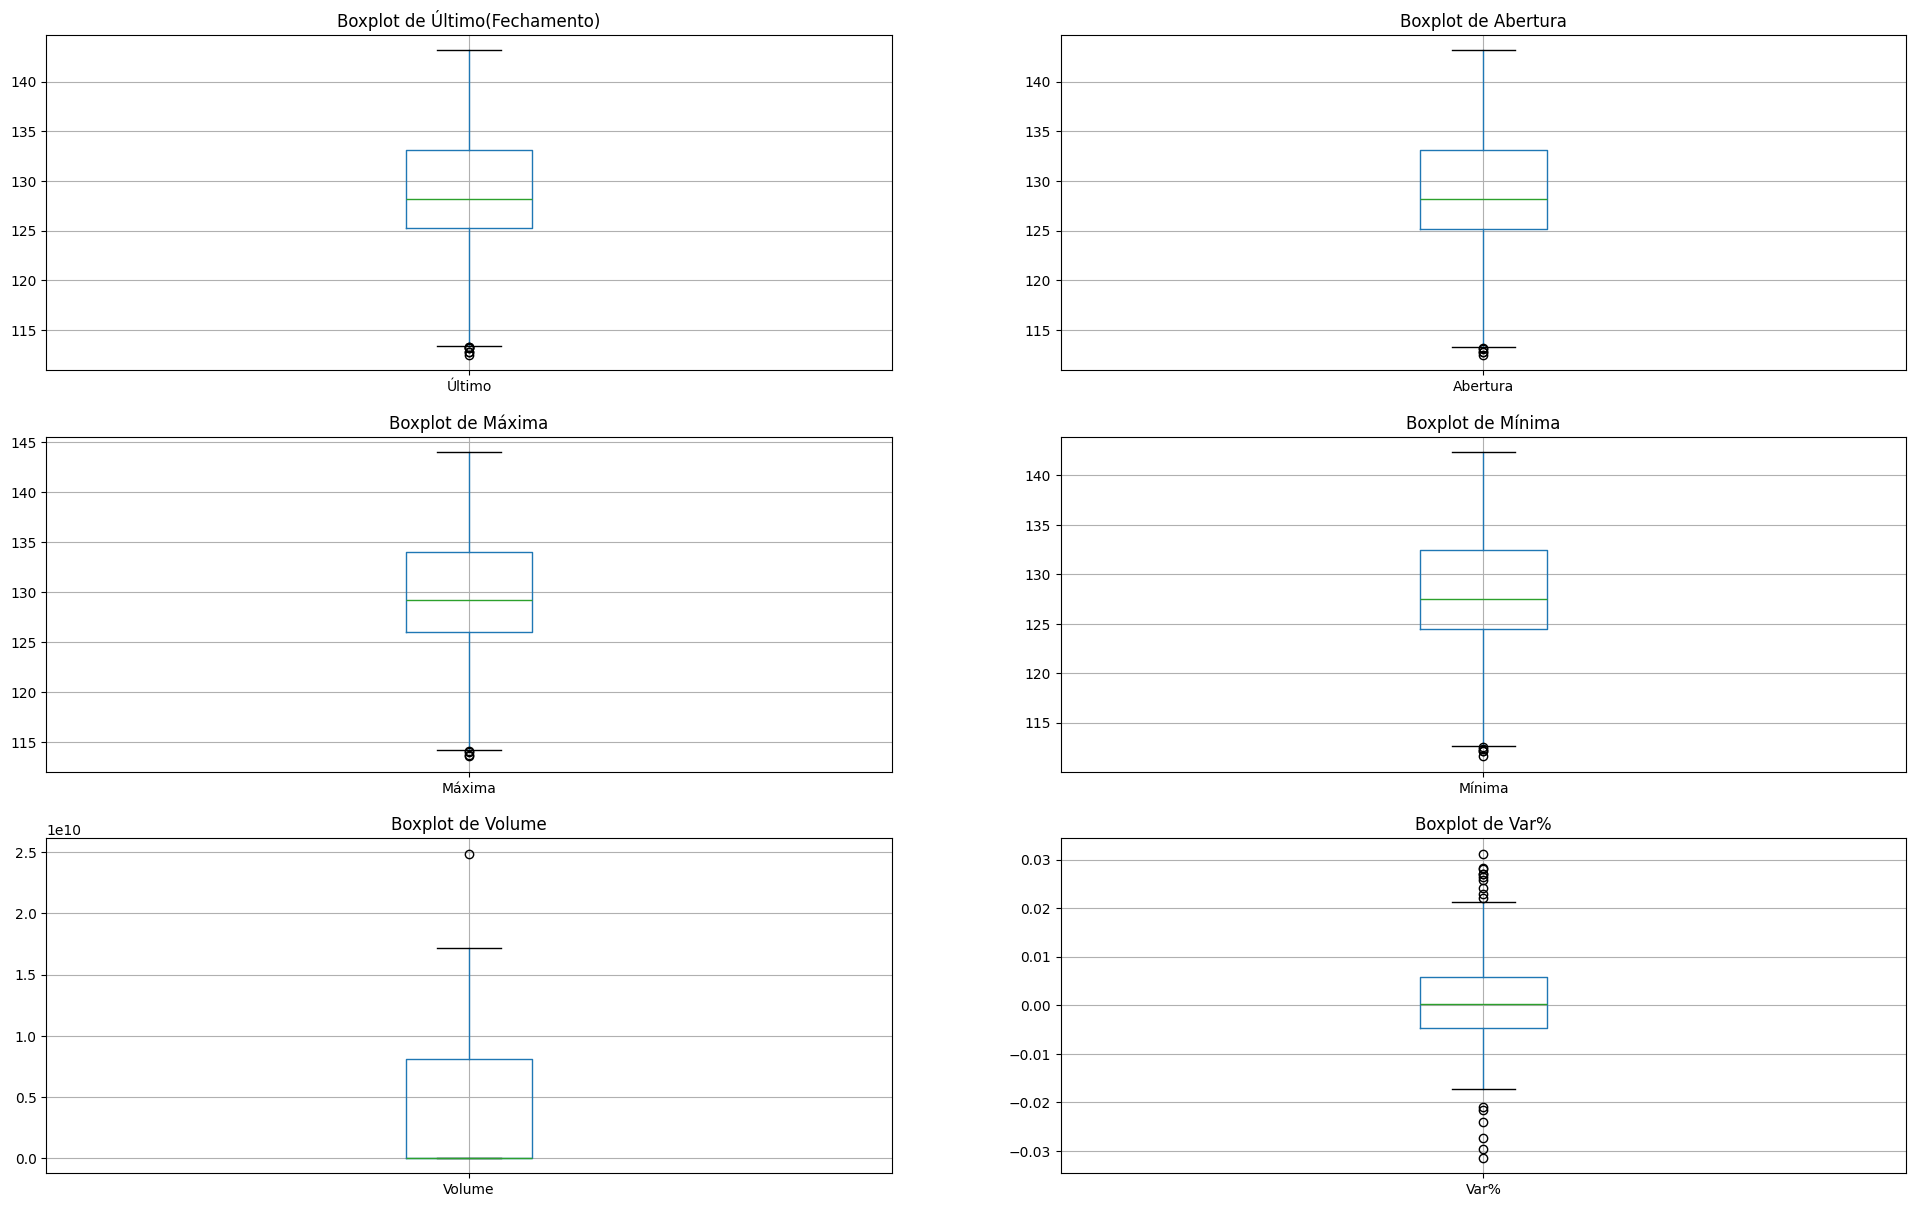

In [16]:
# Criar um gráfico com subplots para visualizar a distribuição dos dados de cada variavel
# ['Último', 'Abertura', 'Máxima', 'Mínima', 'Volume', 'Var%']
# Configurar o gráfico
plt.figure(figsize=(24,20))


plt.subplot(4,2,1)
fig = df_ibovespa.boxplot(column='Último')
fig.set_title('Boxplot de Último(Fechamento)')
fig.set_ylabel('')

plt.subplot(4,2,2)
fig = df_ibovespa.boxplot(column='Abertura')
fig.set_title('Boxplot de Abertura')
fig.set_ylabel('')

plt.subplot(4,2,3)
fig = df_ibovespa.boxplot(column='Máxima')
fig.set_title('Boxplot de Máxima')
fig.set_ylabel('')

plt.subplot(4,2,4)
fig = df_ibovespa.boxplot(column='Mínima')
fig.set_title('Boxplot de Mínima')
fig.set_ylabel('')

plt.subplot(4,2,5)
fig = df_ibovespa.boxplot(column='Volume')
fig.set_title('Boxplot de Volume')
fig.set_ylabel('')

plt.subplot(4,2,6)
fig = df_ibovespa.boxplot(column='Var%')
fig.set_title('Boxplot de Var%')
fig.set_ylabel('')

plt.show()

### Correlações (Base Original)

<Axes: >

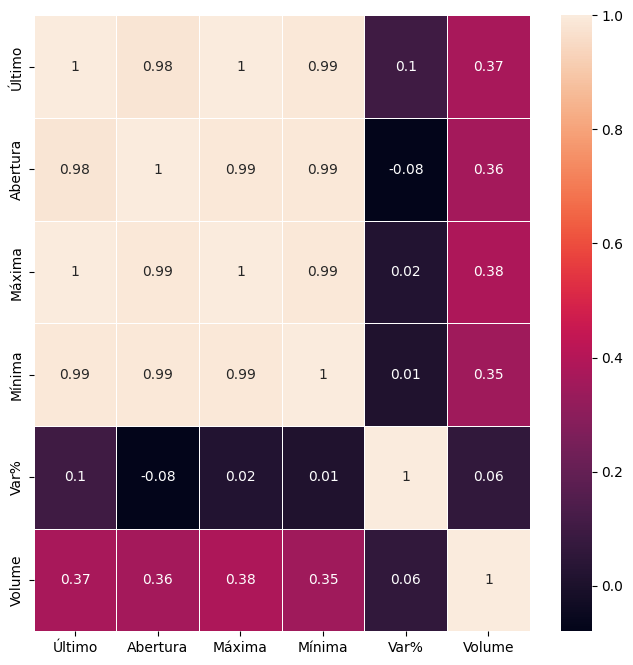

In [17]:
# Matriz de Correlação
correlation_matrix = df_ibovespa.corr(numeric_only=True).round(2)

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(data=correlation_matrix, annot=True, linewidths=.5, ax = ax)

### Tendências e Volatilidade

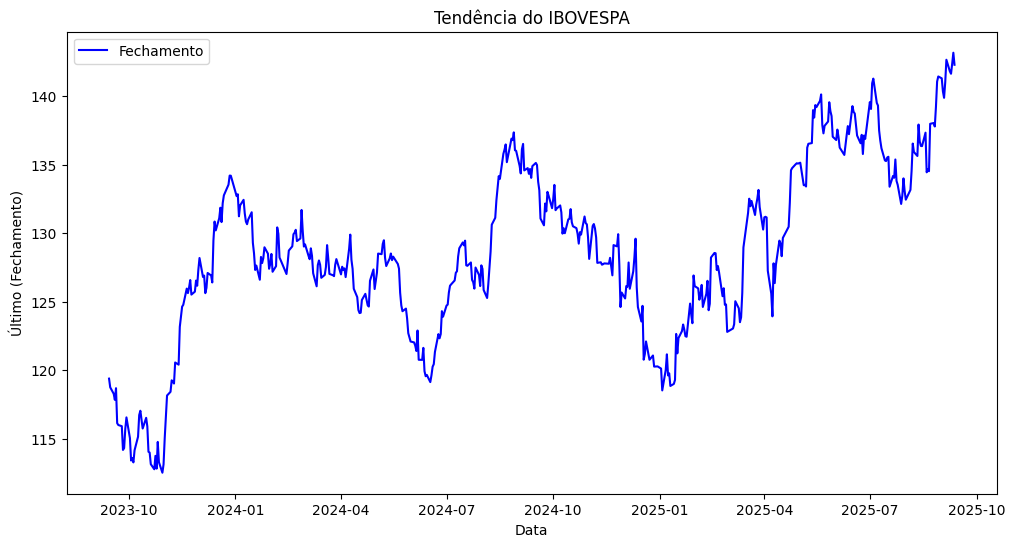

In [18]:
# Criar gráfico de tendencia
plt.figure(figsize=(12,6))
plt.plot(df_ibovespa['Data'], df_ibovespa['Último'], label='Fechamento', color='blue')
plt.title("Tendência do IBOVESPA")
plt.xlabel("Data")
plt.ylabel("Último (Fechamento)")
plt.legend()
plt.show()

#### Padrões Sazonais

Com o propósito de identificar padrões sazonais que possam influenciar os resultados e apoiar previsões futuras, é realizada uma comparação entre os anos, na qual se avalia o comportamento do fechamento mês a mês.

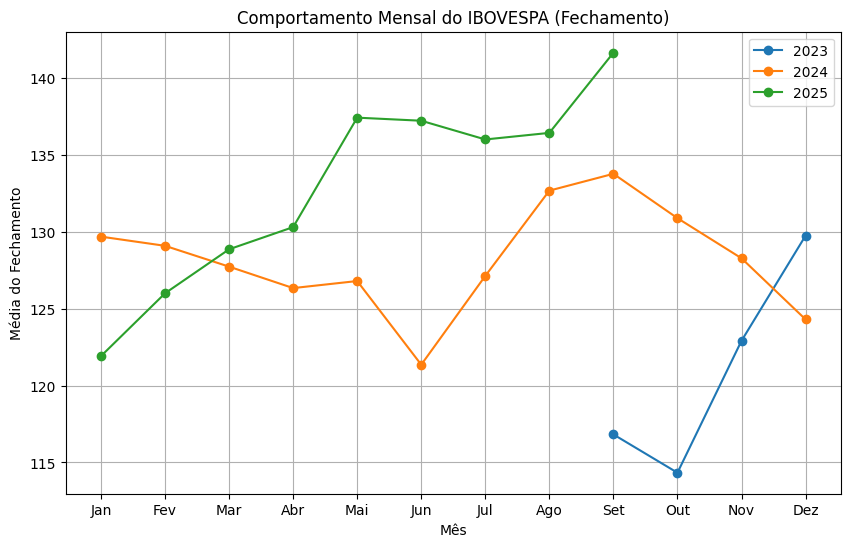

In [19]:
# Criar colunas de Ano e Mês
df_ibovespa['Ano'] = df_ibovespa['Data'].dt.year
df_ibovespa['Mes'] = df_ibovespa['Data'].dt.month

# Calcular a média de fechamento por mês e ano
df_mensal = df_ibovespa.groupby(['Ano','Mes'])['Último'].mean().reset_index()

# Separar por ano
df_2023 = df_mensal[df_mensal['Ano'] == 2023]
df_2024 = df_mensal[df_mensal['Ano'] == 2024]
df_2025 = df_mensal[df_mensal['Ano'] == 2025]

# Gráfico
plt.figure(figsize=(10,6))
plt.plot(df_2023['Mes'], df_2023['Último'], marker='o', label='2023')
plt.plot(df_2024['Mes'], df_2024['Último'], marker='o', label='2024')
plt.plot(df_2025['Mes'], df_2025['Último'], marker='o', label='2025')

plt.title("Comportamento Mensal do IBOVESPA (Fechamento)")
plt.xlabel("Mês")
plt.ylabel("Média do Fechamento")
plt.xticks(range(1,13), ['Jan','Fev','Mar','Abr','Mai','Jun','Jul','Ago','Set','Out','Nov','Dez']) #Para facilitar a leitura
plt.legend()
plt.grid(True)
plt.show()


Conforme a análise, não foram identificados indícios claros de sazonalidade na amostra (set/2023 a set/2025).

## 5. Criação da Target e das Primeiras Features

#### Coluna Target

In [20]:
# Ordenar o DataFrame por data (do mais antigo para o mais recente)
df_ibovespa = df_ibovespa.sort_values('Data').reset_index(drop=True)

# Identificar se o fechamento do dia seguinte é maior do que o fechamento do dia atual. Será considerado a do dia seguinte, pois o modelo deve prever o resultado futuro.
df_ibovespa['Target'] = (df_ibovespa['Último'].shift(-1) > df_ibovespa['Último']).astype(int)
df_ibovespa.head(5)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Unidade Volume,Volume,Ano,Mes,Target
0,2023-09-14,119.392,118.181,119.748,118.181,"13,28M",0.0103,M,13280000.0,2023,9,0
1,2023-09-15,118.758,119.393,119.780,118.666,"16,11M",-0.0053,M,16110000.0,2023,9,0
2,2023-09-18,118.288,118.759,119.486,118.123,"11,27M",-0.0040,M,11270000.0,2023,9,0
3,2023-09-19,117.846,118.288,118.458,117.628,"11,45M",-0.0037,M,11450000.0,2023,9,1
4,2023-09-20,118.695,117.864,119.616,117.847,"9,24M",0.0072,M,9240000.0,2023,9,0


In [21]:
# Criar uma coluna de tendência para identificar queda ou aumento
df_ibovespa['Tendencia'] = np.where(df_ibovespa['Target'] == 1, '↑', '↓')


In [22]:
df_ibovespa

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Unidade Volume,Volume,Ano,Mes,Target,Tendencia
0,2023-09-14,119.392,118.181,119.748,118.181,"13,28M",0.0103,M,1.328000e+07,2023,9,0,↓
1,2023-09-15,118.758,119.393,119.780,118.666,"16,11M",-0.0053,M,1.611000e+07,2023,9,0,↓
2,2023-09-18,118.288,118.759,119.486,118.123,"11,27M",-0.0040,M,1.127000e+07,2023,9,0,↓
3,2023-09-19,117.846,118.288,118.458,117.628,"11,45M",-0.0037,M,1.145000e+07,2023,9,1,↑
4,2023-09-20,118.695,117.864,119.616,117.847,"9,24M",0.0072,M,9.240000e+06,2023,9,0,↓
...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,2025-09-08,141.792,142.640,143.089,141.329,"7,44B",-0.0059,B,7.440000e+09,2025,9,0,↓
495,2025-09-09,141.618,141.794,142.286,141.605,"7,48B",-0.0012,B,7.480000e+09,2025,9,1,↑
496,2025-09-10,142.349,141.612,143.182,141.612,"7,14B",0.0052,B,7.140000e+09,2025,9,1,↑
497,2025-09-11,143.151,142.349,144.013,142.349,"7,57B",0.0056,B,7.570000e+09,2025,9,0,↓


In [23]:
# Conferir o resultado do último dia da base, já que não há dados do dia seguinte para identificar a Target
df_ibovespa.tail()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Unidade Volume,Volume,Ano,Mes,Target,Tendencia
494,2025-09-08,141.792,142.640,143.089,141.329,"7,44B",-0.0059,B,7.440000e+09,2025,9,0,↓
495,2025-09-09,141.618,141.794,142.286,141.605,"7,48B",-0.0012,B,7.480000e+09,2025,9,1,↑
496,2025-09-10,142.349,141.612,143.182,141.612,"7,14B",0.0052,B,7.140000e+09,2025,9,1,↑
497,2025-09-11,143.151,142.349,144.013,142.349,"7,57B",0.0056,B,7.570000e+09,2025,9,0,↓
498,2025-09-12,142.272,143.151,143.202,142.241,"6,39B",-0.0061,B,6.390000e+09,2025,9,0,↓


#### Colunas Features

Criação de features adicionais para melhorar o modelo

In [24]:
#Criar colunas de retorno de curto prazo, calculando a variação percentual do preço de fechamento ('Último') em janelas de 3 e 5 dias
df_ibovespa['Retorno_3d_pct'] = df_ibovespa['Último'].pct_change(periods=3)
df_ibovespa['Retorno_5d_pct'] = df_ibovespa['Último'].pct_change(periods=5)

df_ibovespa

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Unidade Volume,Volume,Ano,Mes,Target,Tendencia,Retorno_3d_pct,Retorno_5d_pct
0,2023-09-14,119.392,118.181,119.748,118.181,"13,28M",0.0103,M,1.328000e+07,2023,9,0,↓,NaN,NaN
1,2023-09-15,118.758,119.393,119.780,118.666,"16,11M",-0.0053,M,1.611000e+07,2023,9,0,↓,NaN,NaN
2,2023-09-18,118.288,118.759,119.486,118.123,"11,27M",-0.0040,M,1.127000e+07,2023,9,0,↓,NaN,NaN
3,2023-09-19,117.846,118.288,118.458,117.628,"11,45M",-0.0037,M,1.145000e+07,2023,9,1,↑,-0.012949,NaN
4,2023-09-20,118.695,117.864,119.616,117.847,"9,24M",0.0072,M,9.240000e+06,2023,9,0,↓,-0.000530,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,2025-09-08,141.792,142.640,143.089,141.329,"7,44B",-0.0059,B,7.440000e+09,2025,9,0,↓,0.013785,0.003603
495,2025-09-09,141.618,141.794,142.286,141.605,"7,48B",-0.0012,B,7.480000e+09,2025,9,1,↑,0.004433,0.009142
496,2025-09-10,142.349,141.612,143.182,141.612,"7,14B",0.0052,B,7.140000e+09,2025,9,1,↑,-0.002040,0.017767
497,2025-09-11,143.151,142.349,144.013,142.349,"7,57B",0.0056,B,7.570000e+09,2025,9,0,↓,0.009584,0.015306


In [25]:
# Criar colunas de médias móveis para suavizar ruídos do mercado. Com janela de 5 e 10 dias.

df_ibovespa['MediaMovel_5d'] = df_ibovespa['Último'].rolling(window=5).mean()
df_ibovespa['MediaMovel_10d'] = df_ibovespa['Último'].rolling(window=10).mean()


df_ibovespa

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Unidade Volume,Volume,Ano,Mes,Target,Tendencia,Retorno_3d_pct,Retorno_5d_pct,MediaMovel_5d,MediaMovel_10d
0,2023-09-14,119.392,118.181,119.748,118.181,"13,28M",0.0103,M,1.328000e+07,2023,9,0,↓,NaN,NaN,NaN,NaN
1,2023-09-15,118.758,119.393,119.780,118.666,"16,11M",-0.0053,M,1.611000e+07,2023,9,0,↓,NaN,NaN,NaN,NaN
2,2023-09-18,118.288,118.759,119.486,118.123,"11,27M",-0.0040,M,1.127000e+07,2023,9,0,↓,NaN,NaN,NaN,NaN
3,2023-09-19,117.846,118.288,118.458,117.628,"11,45M",-0.0037,M,1.145000e+07,2023,9,1,↑,-0.012949,NaN,NaN,NaN
4,2023-09-20,118.695,117.864,119.616,117.847,"9,24M",0.0072,M,9.240000e+06,2023,9,0,↓,-0.000530,NaN,118.5958,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,2025-09-08,141.792,142.640,143.089,141.329,"7,44B",-0.0059,B,7.440000e+09,2025,9,0,↓,0.013785,0.003603,141.1248,140.6355
495,2025-09-09,141.618,141.794,142.286,141.605,"7,48B",-0.0012,B,7.480000e+09,2025,9,1,↑,0.004433,0.009142,141.3814,141.0202
496,2025-09-10,142.349,141.612,143.182,141.612,"7,14B",0.0052,B,7.140000e+09,2025,9,1,↑,-0.002040,0.017767,141.8784,141.3345
497,2025-09-11,143.151,142.349,144.013,142.349,"7,57B",0.0056,B,7.570000e+09,2025,9,0,↓,0.009584,0.015306,142.3100,141.5447


As primeiras linhas nas features criadas, geraram resultados ***NaN***. Isso acontece porque a função não localizou linhas anteriores para fazer o calculo.
Por conta disso os valores NaN são deletados da base para não interferir no modelo ML.

In [26]:
# Deletar as linhas com NaN nas novas features
df_ibovespa_tratado = df_ibovespa.dropna()
df_ibovespa_tratado

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Unidade Volume,Volume,Ano,Mes,Target,Tendencia,Retorno_3d_pct,Retorno_5d_pct,MediaMovel_5d,MediaMovel_10d
9,2023-09-27,114.327,114.193,115.340,113.366,"13,36M",0.0012,M,1.336000e+07,2023,9,1,↑,-0.014499,-0.036800,115.3198,116.9578
10,2023-09-28,115.731,114.327,115.954,114.180,"10,39M",0.0123,M,1.039000e+07,2023,9,1,↑,-0.001673,-0.003565,115.2370,116.5917
11,2023-09-29,116.565,115.742,116.899,115.742,"11,14M",0.0072,M,1.114000e+07,2023,9,0,↓,0.020772,0.004793,115.3482,116.3724
12,2023-10-02,115.057,116.565,116.672,114.761,"8,52M",-0.0129,M,8.520000e+06,2023,10,0,↓,0.006385,-0.007488,115.1746,116.0493
13,2023-10-03,113.419,115.055,115.056,113.151,"11,10M",-0.0142,M,1.110000e+07,2023,10,1,↑,-0.019977,-0.006778,115.0198,115.6066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,2025-09-08,141.792,142.640,143.089,141.329,"7,44B",-0.0059,B,7.440000e+09,2025,9,0,↓,0.013785,0.003603,141.1248,140.6355
495,2025-09-09,141.618,141.794,142.286,141.605,"7,48B",-0.0012,B,7.480000e+09,2025,9,1,↑,0.004433,0.009142,141.3814,141.0202
496,2025-09-10,142.349,141.612,143.182,141.612,"7,14B",0.0052,B,7.140000e+09,2025,9,1,↑,-0.002040,0.017767,141.8784,141.3345
497,2025-09-11,143.151,142.349,144.013,142.349,"7,57B",0.0056,B,7.570000e+09,2025,9,0,↓,0.009584,0.015306,142.3100,141.5447


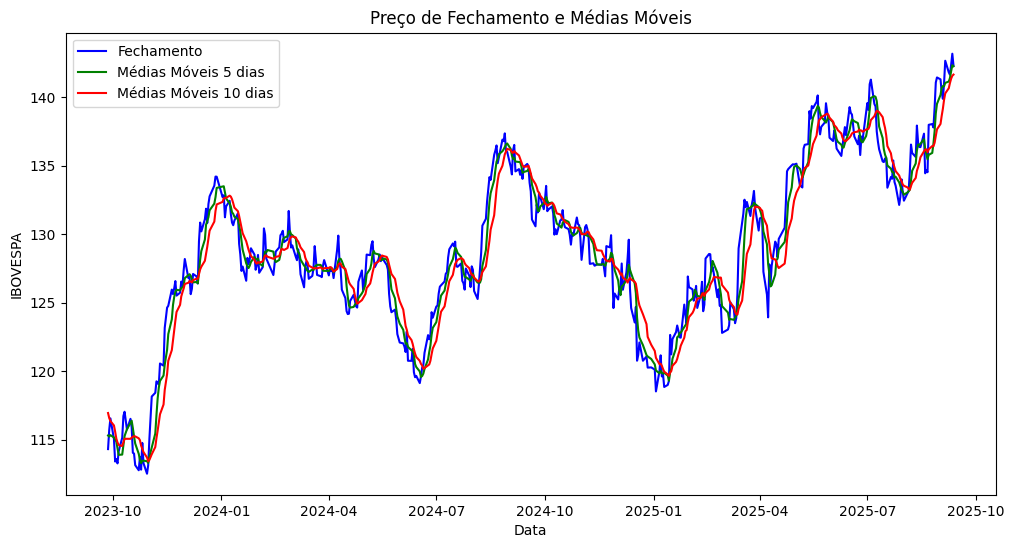

In [27]:
# Visualizar as medias móveis em relação a coluna [Último]
plt.figure(figsize=(12,6))
plt.plot(df_ibovespa_tratado['Data'], df_ibovespa_tratado['Último'], label='Fechamento', color='blue')
plt.plot(df_ibovespa_tratado['Data'], df_ibovespa_tratado['MediaMovel_5d'], label='Médias Móveis 5 dias', color='green')
plt.plot(df_ibovespa_tratado['Data'], df_ibovespa_tratado['MediaMovel_10d'], label='Médias Móveis 10 dias', color='red')


plt.title('Preço de Fechamento e Médias Móveis')
plt.xlabel('Data')
plt.ylabel('IBOVESPA')
plt.legend()
plt.show()

A visualização demonstra o efeito da suavização das Médias Móveis (5 e 10 dias) em relação ao preço de Fechamento [Último].

#### Matriz de Correlação Features e Target

<Axes: >

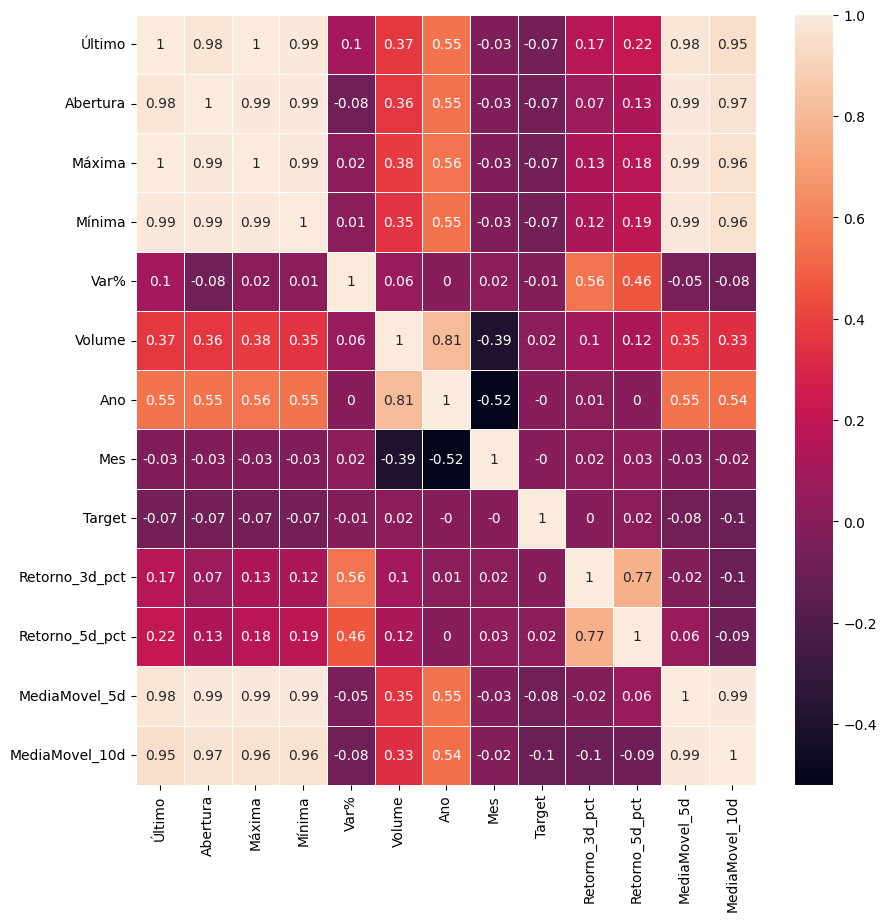

In [28]:
# Matriz de Correlação
correlation_matrix = df_ibovespa.corr(numeric_only=True).round(2)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data=correlation_matrix, annot=True, linewidths=.5, ax = ax)

## 6. Modelos Preditivos (Primeira Fase)

Nesta seção, iniciamos a primeira etapa de modelagem utilizando as features disponíveis até o momento. O objetivo é estabelecer uma linha de base para os modelos de machine learning que podem ser aprimorados posteriormente.

### Identificação das colunas x (features) e y (target)

In [29]:
# Definir as colunas x e y
x_colunas = ['Var%', 'Volume', 'Retorno_3d_pct', 'Retorno_5d_pct', 'MediaMovel_5d', 'MediaMovel_10d']
y_coluna = ['Target']

x:

Var%: Essa feature ajuda a entender o movimento do mercado.

Volume: Nssa feature podemos entender o interesse dos investidores.

Retorno_3d_pct e Retorno_5d_pct: Essas features acompanham a tendência de curto prazo, ampliando a visão além do dia anterior.

MediaMovel_5d e MediaMovel_10d: A lógica é que o modelo deve considerar a direção de longo prazo antes de tomar uma decisão de curto prazo.

y:

Cálculo que identifica se o fechamento do dia seguinte é maior do que do dia atual

### Separação da base para Treino e Teste

Essa etapa separa os dados para a primeira rodada de modelagem, respeitando a ordem temporal e selecionando um conjunto específico de variáveis para treinar e testar o modelo.

Sendo,

Treino: Toda a base, exceto os últimos 30 dias.

Teste: Os últimos 30 dias

In [30]:
# Separar os últimos 30 dias para teste e o restante para treino.
df_train = df_ibovespa_tratado.iloc[:-30]
df_test = df_ibovespa_tratado.iloc[-30:]


x_train = df_train[x_colunas]
x_test = df_test[x_colunas]
y_train = df_train[y_coluna]
y_test = df_test[y_coluna]



### Modelo Naive Bayes

Naive Bayes é um algoritmo de classificação probabilístico baseado no teorema de Bayes.

Ele assume que todas as variáveis preditoras são independentes entre si.

Essa simplificação torna o modelo extremamente rápido, eficiente e escalável.

In [31]:
# Treinar o modelo
gnb = GaussianNB()
gnb.fit(x_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

In [32]:
# Predizendo valores NB
y_pred_NB = gnb.predict(x_test)

#### Validando o Modelo Naive Bayes

In [33]:
# Identificar a acurácia do modelo Naive
acuracia_NB = accuracy_score(y_test, y_pred_NB)*100
print(f"A Acurácia do modelo Naive Bayes é {acuracia_NB:.2f}%")

A Acurácia do modelo Naive Bayes é 50.00%


A Acurácia obtida no teste do modelo Naive Bayes é de 50%. O modelo não atingiu uma previsão assertiva.

Apesar das vantagens do modelo com a rapidez e simplicidade, a previsão do mercado financeiro requer uma abordagem mais complexa.


### Modelo Random Forest Classifier

O modelo de Random Forest cria de forma aleatória várias Árvores de Decisão (Decision Trees) e combina o resultado de todas elas para chegar no resultado final.

In [34]:
# Instanciar o modelo Random Forest e definir os hiperparâmetros
rf = RandomForestClassifier(random_state=7)

In [35]:
# Treinar o modelo RF
rf.fit(x_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=7)

In [36]:
# Testar o modelo RF
y_pred_RF = rf.predict(x_test)

#### Validando Modelo Random Forest Classifier  

In [37]:
acuracia_RF = accuracy_score(y_test, y_pred_RF)*100
print(f"A Acurácia do modelo Random Forest Classifier é de {acuracia_RF:.2f}%")

A Acurácia do modelo Random Forest Classifier é de 50.00%


Com as features atuais o modelo Random Forest Classifier também atingiu apenas 50% de acurácia.


### Modelo KNN Classifier

Ele classifica um novo ponto de dados com base na classe majoritária dos seus vizinhos mais próximos.

A primeira etapa é identificar qual o melhor valor para k

Text(0, 0.5, 'Média de Erro')

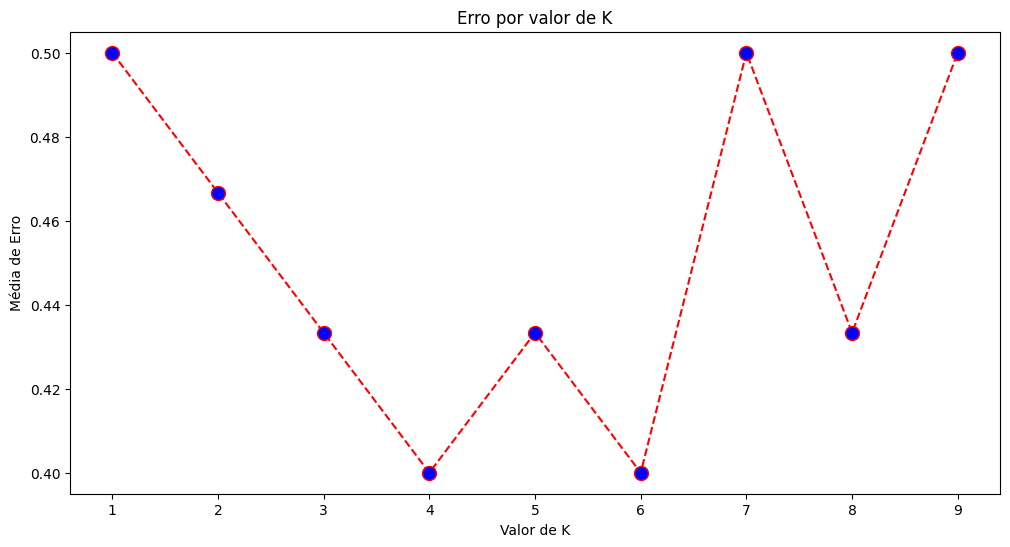

In [38]:
#Criar uma cópia dos valores de x e y para identificar o melhor valor para k
# Separar features e target
x_error = df_ibovespa_tratado[['Var%', 'Volume', 'Retorno_3d_pct', 'Retorno_5d_pct', 'MediaMovel_5d', 'MediaMovel_10d']]
y_error = df_ibovespa_tratado['Target']

# Separar treino e teste (últimos 30 para teste)
x_train = x_error.iloc[:-30]
y_train = y_error.iloc[:-30]
x_test = x_error.iloc[-30:]
y_test = y_error.iloc[-30:]

# Loop para testar diferentes valores de k
error = []

for i in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train, y_train)
    pred_i = knn.predict(x_test)
    error.append(np.mean(pred_i != y_test))

# Visualizar os erros
plt.figure(figsize=(12, 6))
plt.plot(range(1, 10), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Erro por valor de K')
plt.xlabel('Valor de K')
plt.ylabel('Média de Erro')

In [39]:
#Instanciar o modelo KNN
knn = KNeighborsClassifier(n_neighbors=4)

In [40]:
# Treinar o modelo
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=4)

In [41]:
# Testar modelo Knn
y_pred_knn = knn.predict(x_test)

#### Validando Modelo KNN Classifier

In [42]:
acuracia_knn = accuracy_score(y_test, y_pred_knn)*100
print(f"A Acurácia do modelo KNN Classifier (K=4) é: {acuracia_knn:.2f}%")

A Acurácia do modelo KNN Classifier (K=4) é: 60.00%


O modelo Knn Classifier foi o que atingiu a maior acurácia até o momento, chegando a 60%

### Modelo SVM

O SVM é um algoritmo de classificação que busca separar as classes com a maior margem possível. É eficaz em dados complexos e pode usar funções kernel para lidar com separações não lineares.

In [43]:
#Treinar o modelo
svm = Pipeline([
    ("linear_svc", LinearSVC(C=1))
])

svm.fit(x_train, y_train)

Pipeline(steps=[('linear_svc', LinearSVC(C=1))])

In [44]:
#Testar o modelo
y_predito_svm = svm.predict(x_test)

#### Validando o modelo SVM

In [45]:
acuracia_svm = accuracy_score(y_test, y_predito_svm)*100
print(f'A acuracia do modelo SVM é de {acuracia_svm:.2f}%')

A acuracia do modelo SVM é de 50.00%


### Conclusão dos Primeiros Modelos
Os quatro modelos testados não atingiram a acurácia mínima de 75% com as features atuais. Para melhorar os resultados, será necessário criar novas features, além de aplicar técnicas de padronização e escalonamento dos dados para aprimorar a base.

## Padronização e Escalonamento



Para melhorar a eficiencia do modelo, é importante padronizar (colocar na mesma escala) suas variáveis numéricas antes de alimentar um modelo.

Para padronizar as variáveis numéricas usamos a ferramente StandardScaler

In [46]:
# Instanciar StandardScaler
scaler = StandardScaler()

In [47]:
# Calcular a média e o desvio padrão de x utilizando a ferramenta instanciada scaler
scaler.fit(x_train)

x_train_escalonado = scaler.transform(x_train)
x_test_escalonado = scaler.transform(x_test)

In [48]:
# Treinar o modelo escalonado
modelo_classificador = KNeighborsClassifier(n_neighbors=4)

modelo_classificador.fit(x_train_escalonado, y_train)

KNeighborsClassifier(n_neighbors=4)

In [49]:
# Testar modelo escalonado
y_predito_escalonado = modelo_classificador.predict(x_test_escalonado)

In [50]:
# Validação
acuracia_knn_escalonado = accuracy_score(y_test, y_predito_escalonado)*100
print(f'A acuracia desse modelo é de {acuracia_knn_escalonado:.2f}%')

A acuracia desse modelo é de 66.67%


Após a aplicação do escalonamento, observou-se um aumento na acurácia do modelo, que passou a 66%. A etapa seguinte consistirá na revisão dos atributos e no aprimoramento das features, visando atingir 75% de acurácia.

## Engenharia de Atributos

### - Inclusão da Volatilidade

A Volatilidade (desvio padrão), mede o quanto o ativo está “instável”. Quanto maior a volatilidade, mais incerto o movimento.

In [51]:
# Criar as colunas de volatilidade considerando uma janela de 5 e 10 dias
df_ibovespa_reestruturado = df_ibovespa_tratado.copy()
df_ibovespa_reestruturado['Volatilidade_5d'] = df_ibovespa_tratado['Var%'].rolling(window=5).std()
df_ibovespa_reestruturado['Volatilidade_10d'] = df_ibovespa_tratado['Var%'].rolling(window=10).std()


### - Incluir Histórico de Preços Recentes

Essas variáveis representam os preços de fechamento do ativo nos dias anteriores: um e dois dias atras. Essas features permitem que o modelo capture a dinâmica recente do mercado, ajudando a identificar tendências de curto prazo e possíveis padrões de reversão ou continuidade.

In [52]:
# Criar as colunas de histórico de fechamento 1 e 2 dias.
df_ibovespa_reestruturado['Ultimo_1d'] = df_ibovespa_reestruturado['Último'].shift(1)
df_ibovespa_reestruturado['Ultimo_2d'] = df_ibovespa_reestruturado['Último'].shift(2)

### Incluir Indicador de Tendência (Diferença entre Médias Móveis)

A diferença entre a média móvel de 5 dias e a de 10 dias ajuda a capturar sinais de tendência de curto prazo, indicando se o ativo está em movimento de alta ou baixa com base na comparação entre os preços recentes.

In [53]:
# Criar coluna com a diferença entre a média móvel de 5 e 10 dias
df_ibovespa_reestruturado['Dif_MM5_MM10'] = (df_ibovespa_reestruturado['MediaMovel_5d'] - df_ibovespa_reestruturado['MediaMovel_10d'])

É importante tratar os valores nulos caso as novas colunas tenha gerado algum valor em branco.

In [54]:
# Tratar os valores nulos
df_ibovespa_reestruturado = df_ibovespa_reestruturado.dropna()
df_ibovespa_reestruturado

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Unidade Volume,Volume,Ano,...,Tendencia,Retorno_3d_pct,Retorno_5d_pct,MediaMovel_5d,MediaMovel_10d,Volatilidade_5d,Volatilidade_10d,Ultimo_1d,Ultimo_2d,Dif_MM5_MM10
18,2023-10-10,116.737,115.158,116.900,115.158,"11,62M",0.0137,M,1.162000e+07,2023,...,↑,0.030481,0.029254,114.5908,114.8053,0.006423,0.009745,115.156,114.170,-0.2145
19,2023-10-11,117.051,116.737,117.099,116.231,"9,95M",0.0027,M,9.950000e+06,2023,...,↓,0.025234,0.030315,115.2796,115.0777,0.006277,0.009739,116.737,115.156,0.2019
20,2023-10-13,115.754,117.050,117.070,115.658,"10,61M",-0.0111,M,1.061000e+07,2023,...,↑,0.005193,0.021804,115.7736,115.0800,0.009471,0.009908,117.051,116.737,0.6936
21,2023-10-16,116.534,115.760,116.905,115.760,"8,99M",0.0067,M,8.990000e+06,2023,...,↓,-0.001739,0.020706,116.2464,115.0769,0.009383,0.009869,115.754,117.051,1.1695
22,2023-10-17,115.908,116.526,116.917,115.564,"10,37M",-0.0054,M,1.037000e+07,2023,...,↓,-0.009765,0.006530,116.3968,115.1620,0.009792,0.009028,116.534,115.754,1.2348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,2025-09-08,141.792,142.640,143.089,141.329,"7,44B",-0.0059,B,7.440000e+09,2025,...,↓,0.013785,0.003603,141.1248,140.6355,0.008527,0.007551,142.640,140.993,0.4893
495,2025-09-09,141.618,141.794,142.286,141.605,"7,48B",-0.0012,B,7.480000e+09,2025,...,↑,0.004433,0.009142,141.3814,141.0202,0.007632,0.007514,141.792,142.640,0.3612
496,2025-09-10,142.349,141.612,143.182,141.612,"7,14B",0.0052,B,7.140000e+09,2025,...,↑,-0.002040,0.017767,141.8784,141.3345,0.007101,0.007096,141.618,141.792,0.5439
497,2025-09-11,143.151,142.349,144.013,142.349,"7,57B",0.0056,B,7.570000e+09,2025,...,↓,0.009584,0.015306,142.3100,141.5447,0.006784,0.006136,142.349,141.618,0.7653


#### Matriz de Correlação após Engenharia de Atributo

<Axes: >

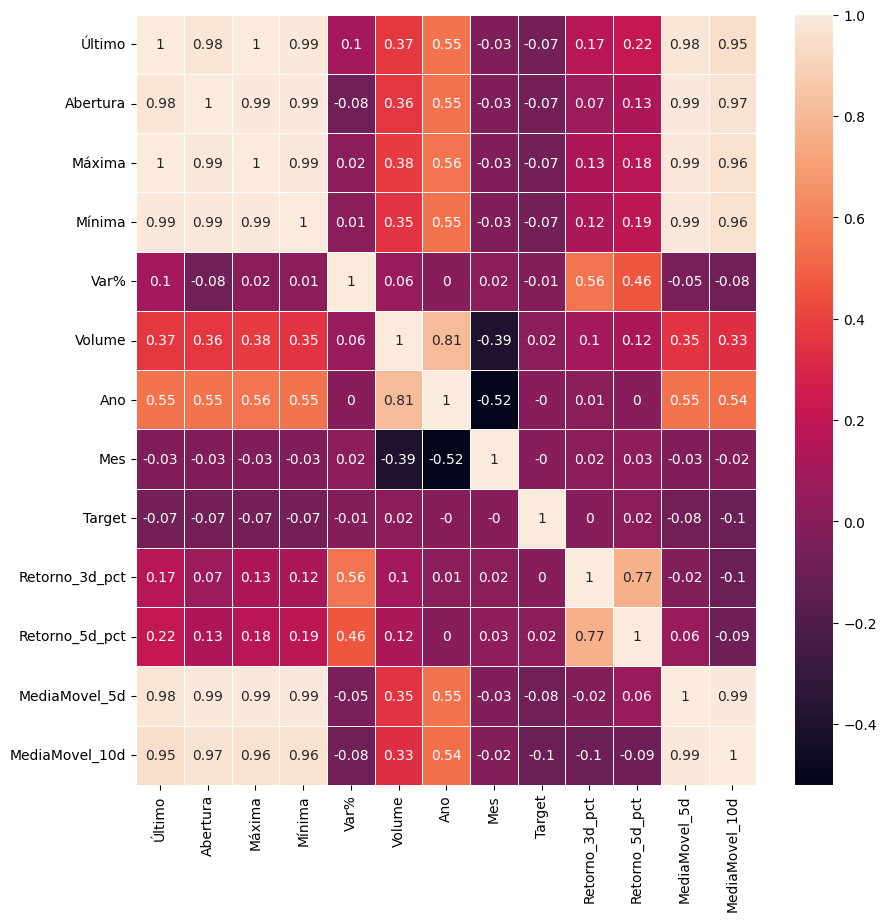

In [55]:
# Matriz de Correlação
correlation_matrix = df_ibovespa.corr(numeric_only=True).round(2)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data=correlation_matrix, annot=True, linewidths=.5, ax = ax)

## Modelos Preditivos (Reestruturado)

Nesta etapa, iniciamos o processo de treino e avaliação dos modelos utilizando a base reestruturada e as novas features criadas. O objetivo é verificar se as melhorias na engenharia de atributos contribuem para o aumento da acurácia preditiva.

### Separação da base para treino e teste (Mantendo a cronologia)

In [56]:
# Identificação das features e target
x_reest_col = ['Retorno_5d_pct', 'Volatilidade_5d', 'Dif_MM5_MM10', 'Ultimo_1d', 'Ultimo_2d']
y_reest_col = ['Target']

In [57]:
# Ordenar por data
df_ibovespa_reestruturado = df_ibovespa_reestruturado.sort_values('Data')

# Separar os últimos 30 dias para teste e o restante para treino
df_train = df_ibovespa_reestruturado.iloc[:-30]
df_test = df_ibovespa_reestruturado.iloc[-30:]

# Identificar x e y para treino e teste
x_train_reest = df_train[x_reest_col]
y_train_reest = df_train[y_reest_col]
x_test_reest = df_test[x_reest_col]
y_test_reest = df_test[y_reest_col]

### Identificar qual o melhor valor para K

Text(0, 0.5, 'Média de Erro')

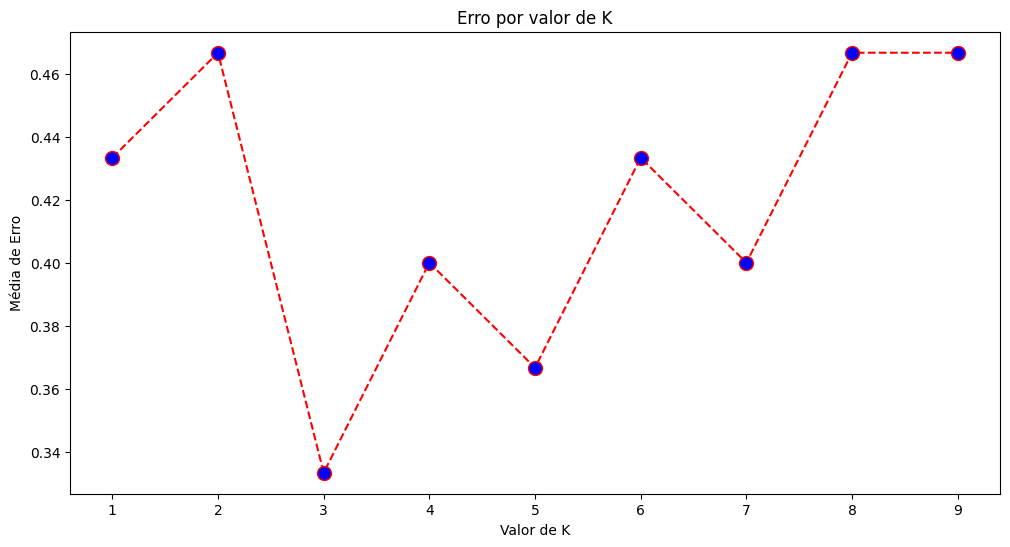

In [58]:
#Criar uma cópia dos valores de x e y para identificar o melhor valor para k
# Separar features e target
x_error = df_ibovespa_reestruturado[['Retorno_5d_pct', 'Volatilidade_5d', 'Dif_MM5_MM10', 'Ultimo_1d', 'Ultimo_2d']]
y_error = df_ibovespa_reestruturado['Target']

# Separar treino e teste (últimos 30 para teste)
x_train = x_error.iloc[:-30]
y_train = y_error.iloc[:-30]
x_test = x_error.iloc[-30:]
y_test = y_error.iloc[-30:]

# Loop para testar diferentes valores de k
error = []

for i in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train, y_train)
    pred_i = knn.predict(x_test)
    error.append(np.mean(pred_i != y_test))

# Visualizar os erros
plt.figure(figsize=(12, 6))
plt.plot(range(1, 10), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Erro por valor de K')
plt.xlabel('Valor de K')
plt.ylabel('Média de Erro')

O melhor valor para k é 3

### Padronização e Escalonamento (Reestruturado)

In [59]:
scaler.fit(x_train_reest)

x_train_escalonado_reest = scaler.transform(x_train_reest)
x_test_escalonado_reest = scaler.transform(x_test_reest)

### Modelo KNN Classifier Reestruturado e Escalonado

In [60]:
# Treinar o modelo escalonado e reestruturado
modelo_classificador = KNeighborsClassifier(n_neighbors=3)

modelo_classificador.fit(x_train_escalonado_reest, y_train_reest)

/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=3)

In [61]:
# Testar modelo escalonado e reestruturado
y_predito_escalonado_reest = modelo_classificador.predict(x_test_escalonado_reest)

#### Validando Modelo Knn Classifier Reestruturado e Escalonado

In [62]:
acuracia_knn_escalonado_reest = accuracy_score(y_test_reest, y_predito_escalonado_reest)*100
print(f'A acuracia desse modelo é de {acuracia_knn_escalonado_reest:.2f}%')

A acuracia desse modelo é de 53.33%


### Modelo Random Forest Reestruturado e Escalonado

In [63]:
# Treinar modelo com dados escalonados e reestruturados
rf.fit(x_train_escalonado_reest, y_train_reest)


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=7)

In [64]:
# Testar o modelo RF reestruturado e Escalonado
y_pred_rf = rf.predict(x_test_escalonado_reest)

In [65]:
accuracy_rf = accuracy_score(y_test_reest, y_pred_rf) * 100
print(f"Acurácia com Random Forest: {accuracy_rf:.2f}%")

Acurácia com Random Forest: 43.33%


### Conclusão Modelos Reestruturados e Escalonados

Mesmo após a reestruturação da base, o uso de escalonamento resultou em uma redução na acurácia dos modelos. Na próxima etapa, serão testados os modelos KNN e Random Forest com a base reestruturada, porém sem escalonamento, para verificar se há melhora no desempenho.

### Modelo Knn Classifier Reestruturado

In [66]:
#Instanciar o modelo KNN
knn_reest = KNeighborsClassifier(n_neighbors=3, weights='distance')

In [67]:
# Treinar o modelo Knn reestruturado
knn_reest.fit(x_train_reest, y_train_reest)


/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=3, weights='distance')

Incluí o parâmetro weights='distance', pois os vizinhos mais próximos terão maior peso na decisão. Ou seja, quanto mais perto o vizinho, mais influência ele tem na classificação.

In [69]:
#Testar o modelo Knn Reestruturado
y_pred_knn_reest = knn_reest.predict(x_test_reest)

#### Validação do Modelo Knn Reestruturado

In [71]:
# Validar o modelo
acuracia_knn_rest = accuracy_score(y_test_reest, y_pred_knn_reest)*100
print(f"A Acurácia do modelo KNN Classifier (K=3) é: {acuracia_knn_rest:.2f}%")

A Acurácia do modelo KNN Classifier (K=3) é: 70.00%


### Modelo Random Forest Reestruturado

In [72]:
# Treinar modelo RF
rf.fit(x_train_reest, y_train_reest)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=7)

In [73]:
# Testar Modelo RF reestruturado
y_pred_rf_reest = rf.predict(x_test_reest)

#### Validar Modelo Random Forest Reestruturado

In [74]:
accuracy_rf_rest = accuracy_score(y_test_reest, y_pred_rf) * 100
print(f"Acurácia com Random Forest: {accuracy_rf_rest:.2f}%")

Acurácia com Random Forest: 43.33%


## Conclusão

O projeto teve como objetivo prever o comportamento diário do Ibovespa, identificando se o fechamento do dia seguinte teria tendência de alta ou queda.

Após as etapas de exploração, limpeza, engenharia de atributos e testes de modelagem, o modelo KNN (K=3) alcançou uma acurácia de 70%, representando um resultado consistente e realista diante da volatilidade do mercado.

O modelo mostrou bom equilíbrio entre simplicidade e desempenho, e os testes realizados ajudaram a compreender o impacto das variáveis de retorno, volatilidade e médias móveis no comportamento dos preços.

Limitações: A previsão é afetada por ruídos e eventos imprevisíveis do mercado financeiro, o que restringe a precisão do modelo.

## Previsão Dia Seguinte

In [75]:
# Selecionar a última linha da base (dia 2025-09-12)
ultimo_dia = df_ibovespa_reestruturado.iloc[-1]

# Calcular as features necessárias
retorno_5d_pct = df_ibovespa_reestruturado['Retorno_5d_pct'].iloc[-1]
volatilidade_5d = df_ibovespa_reestruturado['Volatilidade_5d'].iloc[-1]
dif_mm5_mm10 = df_ibovespa_reestruturado['Dif_MM5_MM10'].iloc[-1]
ultimo_1d = df_ibovespa_reestruturado['Ultimo_1d'].iloc[-1]
ultimo_2d = df_ibovespa_reestruturado['Ultimo_2d'].iloc[-1]

# Criar um DataFrame com os dados do "novo dia"
novo_dado = pd.DataFrame({
    'Retorno_5d_pct': [retorno_5d_pct],
    'Volatilidade_5d': [volatilidade_5d],
    'Dif_MM5_MM10': [dif_mm5_mm10],
    'Ultimo_1d': [ultimo_1d],
    'Ultimo_2d': [ultimo_2d]
})


In [76]:
novo_dado

,Retorno_5d_pct,Volatilidade_5d,Dif_MM5_MM10,Ultimo_1d,Ultimo_2d
0,-0.00258,0.005716,0.6067,143.151,142.349


In [78]:
# Prever a Target para o novo dia
target_prevista = knn_reest.predict(novo_dado)

if target_prevista[0] == 1:
    print("A Tendência prevista para o dia seguinte (13/09/2025) é: ↑")
else:
  print(f"A Target prevista para o dia 2025-09-13 é: ↓")


A Target prevista para o dia 2025-09-13 é: ↓
